<a href="https://colab.research.google.com/github/GhadiElHasbani/NMA_project-FacesHouses/blob/John/load_ECoG_faceshouses_funcs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading of Miller ECoG data of faces/houses (+ noise)

includes some visualizations

In [4]:
# @title Data retrieval
import os, requests

fname = 'faceshouses.npz'
url = "https://osf.io/argh7/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [5]:
# @title Install packages (`nilearn`, `nimare`), import `matplotlib` and set defaults
# install packages to visualize brains and electrode locations
!pip install nilearn --quiet
!pip install nimare --quiet

from matplotlib import rcParams
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [6]:
# @title Data loading
import numpy as np

alldat = np.load(fname, allow_pickle=True)['dat']

In [7]:
# select just one of the recordings here.
dat1 = alldat[1][0]
dat2 = alldat[1][1]
print(len(dat2['key_press']))
print(dat1.keys())
print(dat2.keys())

0
dict_keys(['t_off', 'stim_id', 't_on', 'srate', 'V', 'scale_uv', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])
dict_keys(['stim_id', 'stim_cat', 'stim_noise', 't_on', 't_off', 'key_press', 'V', 'categories', 'scale_uv', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])


# Dataset info #

This is one of multiple ECoG datasets from Miller 2019, recorded in a clinical settings with a variety of tasks. We plan to curate a few more before NMA starts. Raw data here:

https://exhibits.stanford.edu/data/catalog/zk881ps0522

`alldat` contains 7 subjects each with two sessions `dat1` and `dat2`, and was originally used in these publications: 

*Miller, Kai J., et al. "Face percept formation in human ventral temporal cortex." Journal of neurophysiology 118.5 (2017): 2614-2627.*

*Miller, Kai J., et al. "The physiology of perception in human temporal lobe is specialized for contextual novelty." Journal of neurophysiology 114.1 (2015): 256-263.*

*Miller, Kai J., et al. "Spontaneous decoding of the timing and content of human object perception from cortical surface recordings reveals complementary information in the event-related potential and broadband spectral change." PLoS computational biology 12.1 (2016): e1004660.*

*Miller, Kai J., et al. "The physiology of perception in human temporal lobe is specialized for contextual novelty." Journal of neurophysiology 114.1 (2015): 256-263.*

*Miller, Kai J., et al. "Spontaneous decoding of the timing and content of human object perception from cortical surface recordings reveals complementary information in the event-related potential and broadband spectral change." PLoS computational biology 12.1 (2016): e1004660.*

In this task, subjects in a clinical settings (with ECoG implants) are passively shown faces and house during the first experiment (`dat1`). Then in the second experiment in the same subjects (`dat2`), noise is added to face and houses images and the subject has to detect the faces by pressing a key. Two of the subjects don't have keypresses. 

Sample rate is always 1000Hz, and the ECoG data has been notch-filtered at 60, 120, 180, 240 and 250Hz, followed by z-scoring across time and conversion to float16 to minimize size. 

Experiment 1: 
* `dat1['V']`: continuous voltage data (time by channels)
* `dat1['srate']`: acquisition rate (1000 Hz). All stimulus times are in units of this.  
* `dat1['t_on']`: time of stimulus onset in data samples
* `dat1['t_off']`: time of stimulus offset, always 400 samples after `t_on`
* `dat1['stim_id`]: identity of stimulus from 1-100, with 1-50 being houses and 51-100 being faces
* `dat1['locs`]: 3D electrode positions on the brain surface

Experiment 2: 
* `dat2['V`]: continuous voltage data (time by channels)
* `dat2['srate']`: acquisition rate (1000 Hz). All stimulus times are in units of this.  
* `dat2['t_on']`: time of stimulus onset in data samples
* `dat2['t_off']`: time of stimulus offset, always 1000 samples after `t_on`, with no inter-stimulus interval
* `dat2['stim_id`]: identity of stimulus from 1-600 (not really useful, since we don't know which ones are the same house/face)
* `dat2['stim_cat']`: stimulus category (1 = house, 2 = face)
* `dat2['stim_noise']`: percent noise from 0 to 100
* `dat2['key_press']`: when the subject thought the image was a face
* `dat2['categories']`: categories legend (1 = house, 2 = face)
* `dat2['locs`]: 3D electrode positions on the brain surface


In [8]:
from nilearn import plotting
from nimare import utils
from scipy.spatial import distance_matrix
import pandas as pd
import codecs, json 
from tabulate import tabulate

def flatten(xss):
    return [x for xs in xss for x in xs]

def find_dups(locs):
  u, c = np.unique(locs, axis = 0, return_counts=True)
  dup = u[c > 1]
  dup_ids = dict()
  i = 0
  for repeated_group in dup:
    repeated_idx = np.argwhere(np.all(locs == repeated_group, axis=1))
    #dup_ids = np.concatenate((dup_ids, repeated_idx.ravel()), axis = 0)
    dup_ids[i] = repeated_idx.ravel()
    i += 1
  if(len(dup_ids) > 0):
    print(dup_ids)
  else:
    print("No duplicates found")
  #return flatten(dup_ids) if len(dup_ids) > 1 else dup_ids
  return dup_ids

def check_match(V, dup_ids):
  for n, dup_id in dup_ids.items():
      print("Checking channels " + str(dup_id))

      if(len(dup_id) > 2):
        res = np.full((len(dup_id), len(dup_id)), False)

        for i in range(len(dup_id)):
          for j in range(len(dup_id)):
            res[i,j] = np.array_equal(V[:,int(dup_id[i])], V[:,int(dup_id[j])])
      
        print(tabulate(res, showindex = dup_id, headers = dup_id))

      else:
        res = np.array_equal(V[:,int(dup_id[0])], V[:,int(dup_id[1])])
        print(res)
      
def plot_brain(all_data, patient1 = np.nan, patient2 = np.nan, compare = False, all = False):
  plt.figure(figsize=(8, 8))
  
  if(len(all_data) > 0):
    if(all):
      all_locs = all_data[0][0]['locs']
      locs_labels = [str(channel_num)+"_0" for channel_num in np.arange(all_locs.shape[0])]
      locs_colors = ["C0" for i in range(all_locs.shape[0])]

      for pat_id in range(all_data.shape[0] - 1):
        pat_locs = all_data[pat_id + 1][0]['locs']
        all_locs = np.concatenate((all_locs, pat_locs), axis = 0)
        locs_labels = np.append(locs_labels, [str(channel_num)+"_"+str(pat_id + 1) for channel_num in np.arange(pat_locs.shape[0])]).tolist()
        locs_colors = locs_colors + ["C"+str(pat_id + 1) for i in range(pat_locs.shape[0])]

    else:
      locs1 = all_data[patient1][0]['locs']
      if(compare):
        locs2 = all_data[patient2][0]['locs']
        all_locs = np.concatenate((locs1, locs2), axis = 0)
        locs_labels = np.append([str(channel_num)+"_1" for channel_num in np.arange(locs1.shape[0])], 
                                [str(channel_num)+"_2" for channel_num in np.arange(locs2.shape[0])]).tolist()
        locs_colors = ["purple" for i in range(locs1.shape[0])] + ["yellow" for i in range(locs2.shape[0])]

        if(patient1 != patient2):
          print("Distance Matrix for channels of Patient " + str(patient1) + " and " + str(patient2) + ":")
          print(tabulate(distance_matrix(locs1, locs2, p=2), 
                        showindex = [str(channel_num)+"_1" for channel_num in np.arange(locs1.shape[0])],
                        headers = [str(channel_num)+"_2" for channel_num in np.arange(locs2.shape[0])]))
          
          print("Duplicates for Patient " + str(patient2))
          dup_ids = find_dups(locs2)

          if(len(dup_ids) >= 1):
            print("Is channel output identical for each pair of dups?")
            V = all_data[patient2][0]['V'].astype('float32')
            check_match(V, dup_ids)

      else:
        all_locs = locs1
        locs_labels = list(range(locs1.shape[0]))
        locs_colors = ["purple" for i in range(locs1.shape[0])]

      print("Duplicates for Patient " + str(patient1))
      dup_ids = find_dups(locs1)

      if(len(dup_ids) >= 1):
        print("Is channel output identical for each pair of dups?")
        V = all_data[patient1][0]['V'].astype('float32')
        check_match(V, dup_ids)
      
    
    
    view = plotting.view_markers(utils.tal2mni(all_locs),
                                marker_labels= locs_labels,#['%d'%k for k in np.arange(locs.shape[0])],
                                marker_color=locs_colors,
                                marker_size=5)
    
    return view
  else:
    print("No patient data found.")
    return False

ERROR:duecredit:Failed to import duecredit due to No module named 'duecredit'


In [9]:
plot_brain(alldat, patient1 = 1, 
           patient2 = 5, 
           compare = True
           )

Distance Matrix for channels of Patient 1 and 5:
           0_2       1_2       2_2       3_2       4_2       5_2       6_2       7_2       8_2       9_2      10_2      11_2      12_2      13_2      14_2      15_2      16_2      17_2      18_2      19_2      20_2      21_2      22_2      23_2      24_2      25_2      26_2       27_2      28_2      29_2      30_2      31_2      32_2      33_2      34_2      35_2      36_2      37_2      38_2
----  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  ---------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------
 0_1   35.1078   45.0901   52.5711   60.7191   68.0505   75.1726   83.1148   89.2038   84.6096   93.8722  103.361   110.753   118.097   104.21    113.246   120

<Figure size 576x576 with 0 Axes>

In [10]:
# Original matlab code and TDdatabase.mat file from Xu Cui ( https://alivelearn.net/?p=1456 )
# author: Astrid Olave ( https://github.com/aaolaveh/anat-from-MNI/blob/master/functions.py )

import sys
import scipy.io
import warnings
import numpy as np

#----------------------------  find_structure ---------------------------
#Converts MNI coordinate to a description of brain structure in aal
#Input: - mni : the coordinates (MNI) of some points, in mm.  It is Mx3 matrix
#        where each row is the coordinate for one point.
#        -DB (optional): The database. If is omit, make sure TDdatabase.mat is in the 
#        same folder
#Output: -one_line_result: A list of M elements, each describing each point.
#        -table_result:  A  MxN matrix being N the size of the database (DB)
#

def find_structure(mni,DB=None):
    #Copy from cuixuFindStructure.m
    
    #Vectorize this functions
    vstr=np.vectorize(str)
    vround = np.vectorize(my_round)
    vint=np.vectorize(int)
    
    if DB == None:
        mat=scipy.io.loadmat('TDdatabase.mat')
            
    mni=np.array(mni)        
    
    #round coordinates
    mni=vround(mni/2)*2 
    
    T=np.array([[2 ,0 ,0 ,-92],[0,2,0,-128],
                    [0,0,2,-74],[0,0,0,1]])
    
    index=mni2cor(mni,T)
    M=np.shape(index)[0]
    
    #-1 by python indexation
    index=vint(index) - 1 
    
    N=np.shape(mat['DB'])[1]
    table_result=np.zeros((M,N))
    table_result=table_result.tolist() #instead of [i,j] use [i][j]
    
    one_line_result=[""] * M
    
    for i in range(M):
        for j in range(N):
            #mat['DB'][0,j][0,0][0] is the j-th 3D-matrix 
            graylevel=mat['DB'][0,j][0,0][0][index[i,0],index[i,1],index[i,2]] 
            if graylevel == 0:
                 label = 'undefined'
            else:
                if j < (N-1):
                    tmp = ''
                else:
                    tmp =' (aal)' 
                    
                #mat['DB'][0,j][0,0][1]  is the list with regions
                label=mat['DB'][0,j][0,0][1][0,(graylevel-1)][0] + tmp
            
            table_result[i][j]=label
            one_line_result[i] = one_line_result[i] + ' // ' + label
    return(one_line_result,table_result)
    
#---------------------------- mni2cor --------------------------------
# convert mni coordinate to matrix coordinate
#Input: - mni : the coordinates (MNI) of some points, in mm.  It is Mx3 matrix
#        where each row is the coordinate for one point.
#        -T (optional): transform matrix coordinate is the returned coordinate in matrix.
#Output: -coords : Coordinate matrix
#
def mni2cor(mni,T=np.array([[-4 ,0 ,0 ,84],[0,4,0,-116],
                    [0,0,4,-56],[0,0,0,1]])):
    
    mni=np.array(mni)
    
    if len(np.shape(mni))==1:
        mni=mni.reshape((1, len(mni)))
    
    if np.shape(mni)[1] != 3:
        warnings.warn('are not 3-length coordinates')
        return(np.array([]))
        
    a=np.hstack((mni,np.ones((np.shape(mni)[0],1))))
    b=np.transpose(np.linalg.inv(T))
    coords=a.dot(b)
    coords=coords[:,0:3]
        
    vround = np.vectorize(my_round)
    coords = vround(coords)
    return(coords)
    
#-------------------------- my_round ------------------------------
# round function to integer to match with round in MATLAB
# Input: -x: value to be rounded
# Output: rounded x
def my_round(x):
    r=x-np.floor(x)
    if(r == 0.5):
        if x<0: return(x-0.5)
        else: return(x+0.5)
    else:
        return(round(x))

In [11]:
#one_line_res, table_res = find_structure(alldat[4][0]['locs'])
#print(tabulate(table_res, showindex = list(range(len(alldat[4][0]['locs'])))))
#plot_brain(alldat, patient1 = 4)
#print(np.argwhere(np.array(table_res)[:,5] != 'undefined'))
#print(len(find_dups(alldat[4][0]['locs'])))
import copy

def intersect(x):
  result = set(x[0])
  for entry in x:
    result = result.intersection(set(x[entry]))
  print(result)
  return result

def clean_channels(all_data, remove_dups = True, map = False, match_by = 'gyrus'):
  res_locations = {}
  res_channels = {}
  considered_ids = np.full((all_data.shape[0],), True)
  
  for pat_id in range(all_data.shape[0]):
    print("Processing Patient #" + str(pat_id))
    
    if(len(all_data[pat_id][1]['key_press']) == 0):
      print("Excluding Patient " + str(pat_id)+ " with no key-press")
      considered_ids[pat_id] = False
      continue

    data = copy.deepcopy(all_data[pat_id])
    locs = data[0]['locs']
    channels = list(range(locs.shape[0]))
    clean_channels = np.array(channels)
    
    if(remove_dups):
      print("Finding Duplicates")
      dup_ids = find_dups(locs)
      if(len(dup_ids) == 1):
        clean_channels = clean_channels[[clean_channel not in dup_ids[0] for clean_channel in clean_channels]]
      elif(len(dup_ids) > 1):
        for i in range(len(dup_ids)):
          clean_channels = clean_channels[[clean_channel not in dup_ids[i] for clean_channel in clean_channels]]

    if(map):
      one_line_res, table_res = find_structure(locs)
      table_res = np.array(table_res)
      undefined_channels = np.argwhere(table_res[:,5] == 'undefined')
      clean_channels = clean_channels[[clean_channel not in undefined_channels for clean_channel in clean_channels]]

      location_ids = table_res[clean_channels,5]
      res_locations[pat_id] = location_ids
      res_channels[pat_id] = clean_channels
    else:
      res_locations[pat_id] = np.array(data[0][match_by])[clean_channels]
      res_channels[pat_id] = clean_channels

  print("Common regions:")
  common_locations = intersect(res_locations)

  clean_data = copy.deepcopy(all_data)
  for pat_id in np.array(range(all_data.shape[0]))[considered_ids]:

    clean_channels = res_channels[pat_id][[location_id in common_locations for location_id in res_locations[pat_id]]]
    print("Channels left for Patient #" + str(pat_id) + " after intersection")
    print(clean_channels)

    clean_data[pat_id][0]['pat_id'] = pat_id
    clean_data[pat_id][0]['locs'] = clean_data[pat_id][0]['locs'][clean_channels]
    clean_data[pat_id][0]['V'] = clean_data[pat_id][0]['V'][:,clean_channels]
    clean_data[pat_id][0]['clean_channels'] = clean_channels
    clean_data[pat_id][1]['locs'] = clean_data[pat_id][1]['locs'][clean_channels]
    clean_data[pat_id][1]['V'] = clean_data[pat_id][1]['V'][:,clean_channels]
    clean_data[pat_id][1]['clean_channels'] = clean_channels
    
    if(map):
      clean_data[pat_id][0]['mapped_channel_locs'] = res_locations[pat_id][[location_id in common_locations for location_id in res_locations[pat_id]]]
      clean_data[pat_id][1]['mapped_channel_locs'] = res_locations[pat_id][[location_id in common_locations for location_id in res_locations[pat_id]]]
    else:
      clean_data[pat_id][0]['hemisphere'] = np.array(clean_data[pat_id][0]['hemisphere'])[clean_channels].tolist()
      clean_data[pat_id][0]['lobe'] = np.array(clean_data[pat_id][0]['lobe'])[clean_channels].tolist()
      clean_data[pat_id][0]['gyrus'] = np.array(clean_data[pat_id][0]['gyrus'])[clean_channels].tolist()
      clean_data[pat_id][0]['Brodmann_Area'] = np.array(clean_data[pat_id][0]['Brodmann_Area'])[clean_channels].tolist()
      clean_data[pat_id][1]['hemisphere'] = np.array(clean_data[pat_id][1]['hemisphere'])[clean_channels].tolist()
      clean_data[pat_id][1]['lobe'] = np.array(clean_data[pat_id][1]['lobe'])[clean_channels].tolist()
      clean_data[pat_id][1]['gyrus'] = np.array(clean_data[pat_id][1]['gyrus'])[clean_channels].tolist()
      clean_data[pat_id][1]['Brodmann_Area'] = np.array(clean_data[pat_id][1]['Brodmann_Area'])[clean_channels].tolist()

  for pat_id in np.array(range(all_data.shape[0]))[considered_ids == False]:
    if(len(all_data[pat_id][1]['key_press']) == 0):
      clean_data = np.delete(clean_data, pat_id, 0)
      continue
  return clean_data, considered_ids
  

In [12]:
print(alldat[4][0].keys())
clean_alldat, _ = clean_channels(alldat, map = False, match_by = 'gyrus')
print(clean_alldat.shape)
#clean_alldat[2][1]['gyrus']

plot_brain(clean_alldat, patient1 = 0, 
           patient2 = 0, 
           compare = True,
           all = True
           )

dict_keys(['t_off', 'stim_id', 't_on', 'srate', 'V', 'scale_uv', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])
Processing Patient #0
Finding Duplicates
No duplicates found
Processing Patient #1
Excluding Patient 1 with no key-press
Processing Patient #2
Excluding Patient 2 with no key-press
Processing Patient #3
Finding Duplicates
{0: array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59])}
Processing Patient #4
Finding Duplicates
{0: array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57])}
Processing Patient #5
Finding Duplicates
No duplicates found
Processing Patient #6
Finding Duplicates
No duplicates found
Common regions:
{'Fusiform Gyrus', 'Inferior Temporal Gyrus', 'Parahippocampal Gyrus'}
Channels left for Patient #0 after intersection
[ 7  9 10 14 18 19 22 23 24 25 26 29 30 31 32 35 36 37 38]


<Figure size 576x576 with 0 Axes>

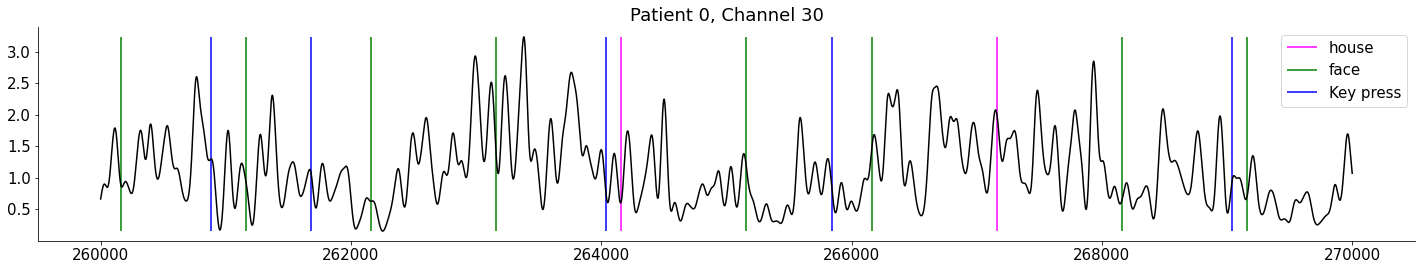

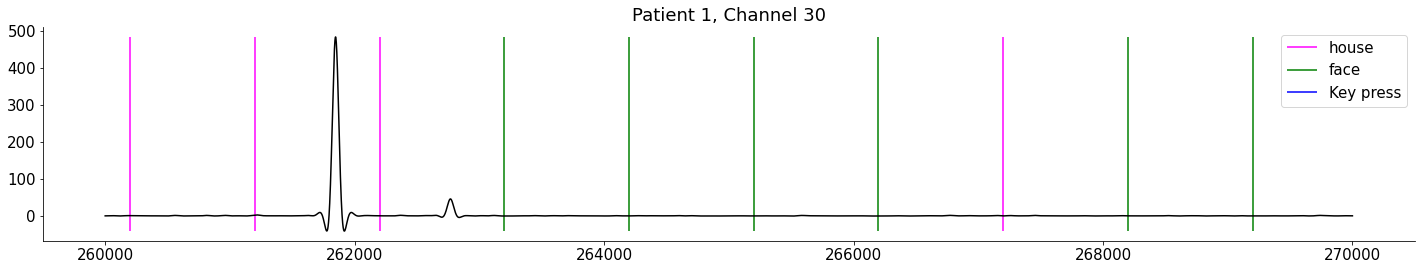

In [13]:
from scipy import signal

def apply_filters(V):
  # quick way to get broadband power in time-varying windows
  b, a = signal.butter(3, [50], btype='high', fs=1000)
  V = signal.filtfilt(b, a, V, 0)
  V = np.abs(V)**2
  b, a = signal.butter(3, [10], btype='low', fs=1000)
  V = signal.filtfilt(b, a, V, 0)

  return V/V.mean(0)

def plot_channels(all_data, noisy = False, patients = [0], xstart = 2000, xend = 15000, ystart = [0], yend = [0]):
  for i in range(len(patients)):
    pat_id = patients[i]
    if(noisy):
      data = all_data[pat_id][1]
      press_t = data['key_press'][(data['key_press'] >= xstart) & (data['key_press'] <= xend)]
      stim_cat = data['stim_cat']
      stim_cat = stim_cat.reshape((len(stim_cat),))
      cats = data['categories']
    else:
      data = data[pat_id][0]
      stim_cat = [1 if id <= 50 else 2 for id in data['stim_id']]
      cats = {'1': "House", '2': "Face"}

    stim_t = data['t_on'][(data['t_on'] >= xstart) & (data['t_on'] <= xend)]
    stim_ids = np.argwhere((data['t_on'] >= xstart) & (data['t_on'] <= xend)).ravel()
    stim_cat = np.array(stim_cat)[stim_ids.astype(int)]
    
    data = apply_filters(data['V'].astype('float32'))
    data = pd.DataFrame(data).iloc[xstart:(xend+1),ystart[i]:(yend[i]+1)]

    for channel in range(data.shape[1]):
      plt.figure()
      ymax = np.max(data.iloc[:,channel])
      ymin = np.min(data.iloc[:,channel])
      data.iloc[:,channel].plot(color = "black", label = '')
      plt.vlines(stim_t[stim_cat == 1], ymin = ymin, ymax = ymax, color = "magenta", label = cats['1'])
      plt.vlines(stim_t[stim_cat == 2], ymin = ymin, ymax = ymax, color = "green", label = cats['2'])
      if(noisy):
        plt.vlines(press_t, ymin = ymin, ymax = ymax, color = "blue", label = "Key press")
      plt.title("Patient " + str(pat_id) + ", Channel "+ str(channel+ystart[i]))
      plt.legend()
  plt.tight_layout()
  plt.show()

plot_channels(all_data = alldat, 
              noisy = True, 
              patients = [0, 1], 
              ystart = [30, 30], 
              yend = [30, 30], 
              xstart = 260000, 
              xend = 270000)

(300, 800, 50)


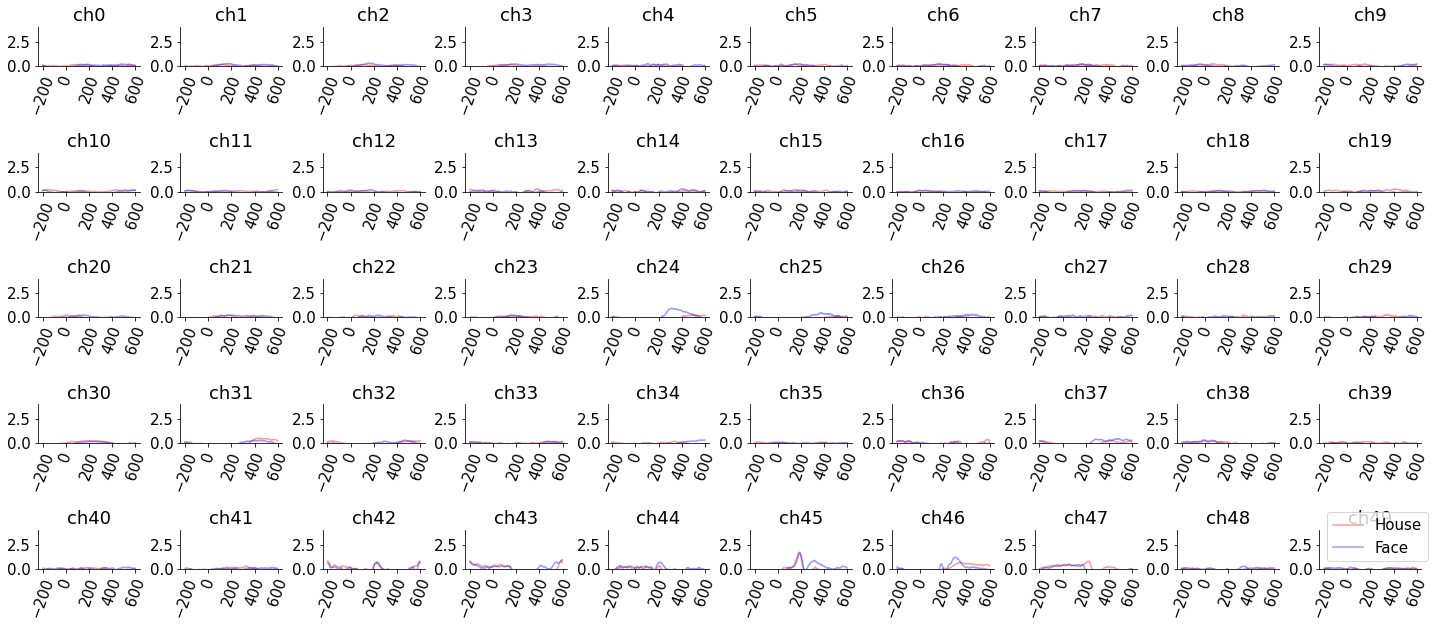

(630, 800, 50)


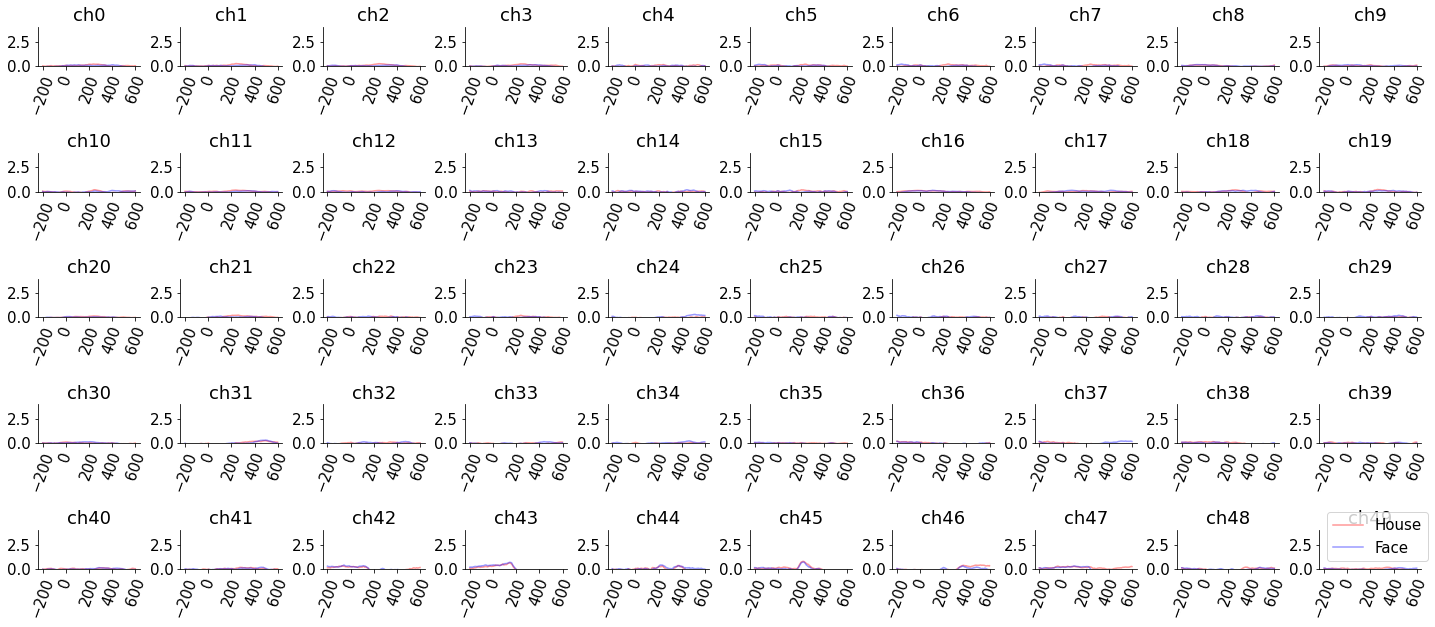

In [46]:
from itertools import chain

def get_epochs(all_data, patient, 
               start = -200, end = 600, 
               noisy = False, 
               subset = True, average = True, median = False,
               plot_house = True, plot_face = True):
  # average the broadband power across all face stimuli and across all house stimuli
  data = all_data[patient][int(noisy)]
  #V = apply_filters(data['V'].astype('float32'))
  V = data['V'].astype('float32')
  nt, nchan = V.shape
  nstim = len(data['t_on'])

  trange = np.arange(start, end)
  ts = data['t_on'][:, np.newaxis] + trange
  V_epochs = np.reshape(V[ts, :], (nstim, end - start, nchan))
  print(V_epochs.shape)
  if(subset):
    if(noisy):
      V_house = V_epochs[list(chain(*data['stim_cat'] == 1 ))]
      V_face = V_epochs[list(chain(*data['stim_cat'] == 2 ))]
    else:
      V_house = V_epochs[data['stim_id'] <= 50]
      V_face = V_epochs[data['stim_id'] > 50]
    
    if(average):
      V_house = V_house.mean(0)
      V_face = V_face.mean(0)
    elif(median):
      V_house = np.median(V_house, axis = 0)
      V_face = np.median(V_face, axis = 0)
    
    # Plotting
    if(plot_house | plot_face):
      plt.figure(figsize=(20, 10))
      if(average | median):
        for j in range(V_house.shape[1]):
          ax = plt.subplot(6, 10, j+1)
          if(plot_house):
            plt.plot(trange, V_house[:, j], color = "r", label = "House", alpha=0.4)
          if(plot_face):
            plt.plot(trange, V_face[:, j], color = "b", label = "Face", alpha=0.4)
        
          plt.title('ch%d'%j)
          plt.xticks([-200, 0, 200, 400, 600], rotation = 70)
          plt.ylim([0, max(max(np.max(V_house[:, j]), np.max(V_face[:, j])), 4)])
        plt.legend()
        plt.show()
      else:
        for j in range(V_house.shape[2]):
          ax = plt.subplot(6, 10, j+1)
          for i in range(V_house.shape[0]):
            if(plot_house):
              plt.plot(trange, V_house[i, :, j], color = "r", label = "House", alpha=0.4)
            if(plot_face):
              plt.plot(trange, V_face[i, :, j], color = "b", label = "Face", alpha=0.4)
          
          plt.title('ch%d'%j)
          plt.xticks([-200, 0, 200, 400, 600], rotation = 70)
          plt.ylim([0, max(np.max(V_house[:, :, j]),np.max(V_face[:, :, j]), 4)])
        plt.legend()
        plt.show()

    return V_house, V_face
  else:
    return V_epochs

epochs_0h, epochs_0f = get_epochs(alldat, patient = 1, noisy = False) #could add average = False
epochs_0h_n, epochs_0f_n = get_epochs(alldat, patient = 1, noisy = True)

(630, 800, 50)
(0, 50) (0, 50)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


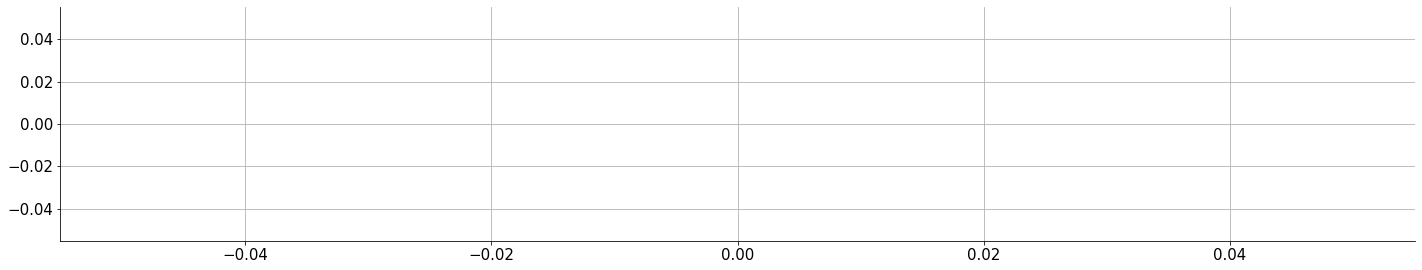

(315, 50)

In [72]:
from scipy.fft import fft, fftfreq
import numpy as np
epochs_0h_n,epochs_0f_n= get_epochs(alldat , 1,start=-200, end=600, noisy = True, subset = True, average = False , median = False, plot_house = False, plot_face = False)
# Number of sample points

# Number of sample points

N = len(epochs_0h_n[:,43])
N2 = len(epochs_0f_n[:,43])

# sample spacing

T = 1.0 / len(epochs_0h_n[:,43])

T2= 1.0 / len(epochs_0f_n[:,43])

#x = np.linspace(0.0, N*T, N, endpoint=False)

y = epochs_0h_n[:,43]
y2 = epochs_0f_n[:,43]
yf = fft(y)
yf2= fft(y2)

xf = fftfreq(N, T)[:N//2]
xf2 = fftfreq(N2, T2)[:N2//2]

import matplotlib.pyplot as plt
power1 = np.log10(2.0/N * (np.abs(yf[0:N//2])))*20
power2 = np.log10(2.0/N2 * (np.abs(yf2[0:N2//2])))*20
print(power1.shape,power2.shape)



plt.plot(np.mean(power1,axis = 0))
plt.plot(np.mean(power2 ,axis= 0) ,color = 'green')


plt.grid()

plt.show()
epochs_0h_n.shape
yf.shape


In [38]:

epochs_0h_n.shape

(800, 50)

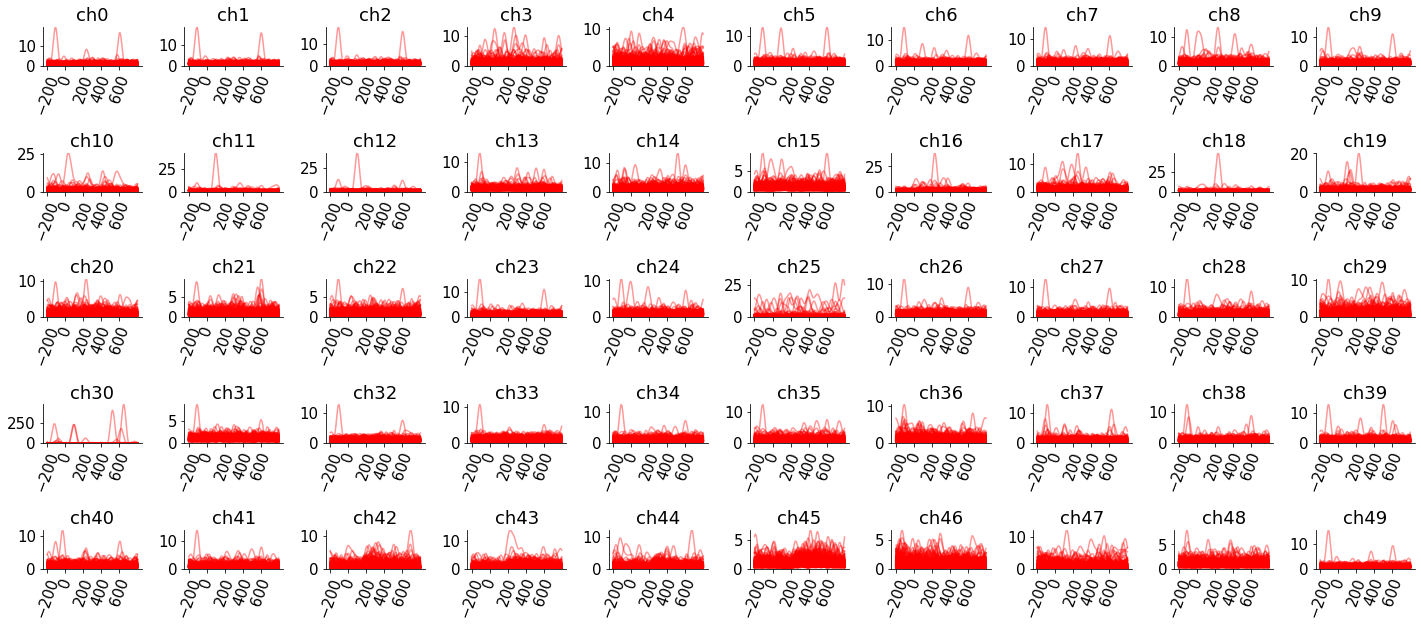

In [ ]:
# let's find the electrodes that distinguish faces from houses
plt.figure(figsize=(20, 10))
for j in range(V_house.shape[2]):
  ax = plt.subplot(6, 10, j+1)
  for i in range(V_house.shape[0]):
    plt.plot(trange, V_house[i, :, j], color = "r", label = "House", alpha=0.4)
    #plt.plot(trange, V_face[i, :, j], color = "b", label = "Face", alpha=0.4)
  plt.title('ch%d'%j)
  plt.xticks([-200, 0, 200, 400, 600], rotation = 70)
  plt.ylim([0, np.max(V_house[:, :, j])])
plt.show()

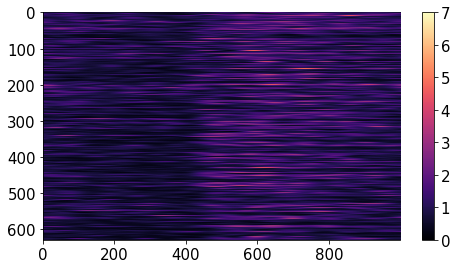

In [ ]:
# let's look at all the face trials for electrode 46 that has a good response to faces
# we will sort trials by stimulus id (1-50 is houses, 51-100 is faces)
plt.subplot(1, 3, 1)
isort = np.argsort(dat2['stim_id'])
plt.imshow(V_epochs[isort, :, 46].astype('float32'),
           aspect='auto', vmax=7, vmin=0,
           cmap='magma')
plt.colorbar()
plt.show()

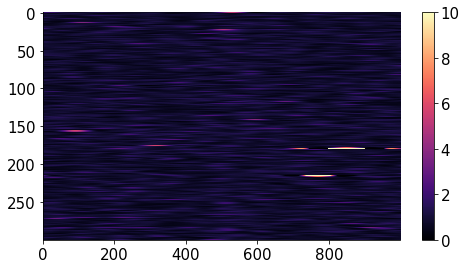

In [ ]:
# Electrode 43 seems to respond to houses
isort = np.argsort(dat1['stim_id'])
plt.subplot(1, 3, 1)
plt.imshow(V_epochs[isort, :, 30].astype('float32'),
           aspect='auto', vmax=10, vmin=0,
           cmap='magma')
plt.colorbar()
plt.show()